<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy as  np
import pandas as pd
import seaborn as sns
from scipy import stats 

In [2]:
sns.__version__

'0.10.0'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [3]:
dataset = pd.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [4]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [6]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [7]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [8]:
dataset = dataset[important_cols].replace('-', np.nan)
for score_col in score_cols:
  dataset[score_col] = pd.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  3. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  4. ¿Tiene sentido calcular la moda?
  5. ¿Cómo pueden sanearse los valores faltantes?
  6. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

##### 1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.

El rango de las variables lo calcularemos como la distancia entre el valor mínimo que asume la variable y su valor máximo dentro del Dataset. Para ello selecciono las variables numericas y aplico una función creada para calcular el mínimo y máximo de cada variable y luego el rango de la misma

In [9]:
col_numerics = dataset[['year',
                     'pf_identity_sex_male',
                     'pf_identity_sex_female',
                     'pf_identity_sex',
                     'pf_identity_divorce',
                     'pf_identity',
                     'pf_score',
                     'pf_rank',
                     'ef_score',
                     'ef_rank',
                     'hf_score',
                     'hf_rank']]
    
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])
      
rango_variables = col_numerics.apply(minMax).T

rango_variables['rango']=rango_variables['max']-rango_variables['min']

In [10]:
print(rango_variables)

                            min      max   rango
year                    2008.00  2017.00    9.00
pf_identity_sex_male       0.00    10.00   10.00
pf_identity_sex_female     0.00    10.00   10.00
pf_identity_sex            0.00    10.00   10.00
pf_identity_divorce        0.00    10.00   10.00
pf_identity                0.00    10.00   10.00
pf_score                   2.22     9.56    7.34
pf_rank                    1.00   162.00  161.00
ef_score                   2.58     9.11    6.53
ef_rank                    1.00   162.00  161.00
hf_score                   3.69     9.12    5.43
hf_rank                    1.00   162.00  161.00


#####  2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 

**Respuesta:** El conjunto de datos tiene realizaciones para los distintos países entre los períodos 2008-2017. Si se pretende realizar una comparación entre dos países debemos tener en cuenta todas las observaciones del período dado que reflejaría mejor el comportamiento de cada país. Al mismo tiempo la medida a utilizarse que condense mejor la información de cada período dado que es un índice que puede evolucionar en el tiempo debería ser la media ya que la variable tiene valores acotados entre 0 - 10 y se trata de países individuales. En el caso de regiones es conveniente la utilización de la media ya que una región contiene más de un país y por ende este país puede constituirse en un outlier. Un ejemplo actual es el caso de Venezuela en la región que ha visto deteriorados muchísimos indicadores de distinto tipo y por lo tanto constituye un outliers para Latinoamérica distorsionando los valores medios de la región.

In [11]:
dataset.countries.unique()

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Central Afr. Rep.', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo, Dem. R.', 'Congo, Rep. Of', 'Costa Rica', "C?te d'Ivoire",
       'Croatia', 'Cyprus', 'Czech Rep.', 'Denmark', 'Dominican Rep.',
       'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Eswatini',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaic

In [12]:
dataset.region.unique()

array(['Eastern Europe', 'Middle East & North Africa',
       'Sub-Saharan Africa', 'Latin America & the Caribbean',
       'Caucasus & Central Asia', 'Oceania', 'Western Europe',
       'South Asia', 'North America', 'East Asia'], dtype=object)

 Una forma de ver cuan representativa es la media es hacer un barplot a traves del paquete seaborn y y poner como estimator la mediana y otro grafico cuyo estimador sea la media

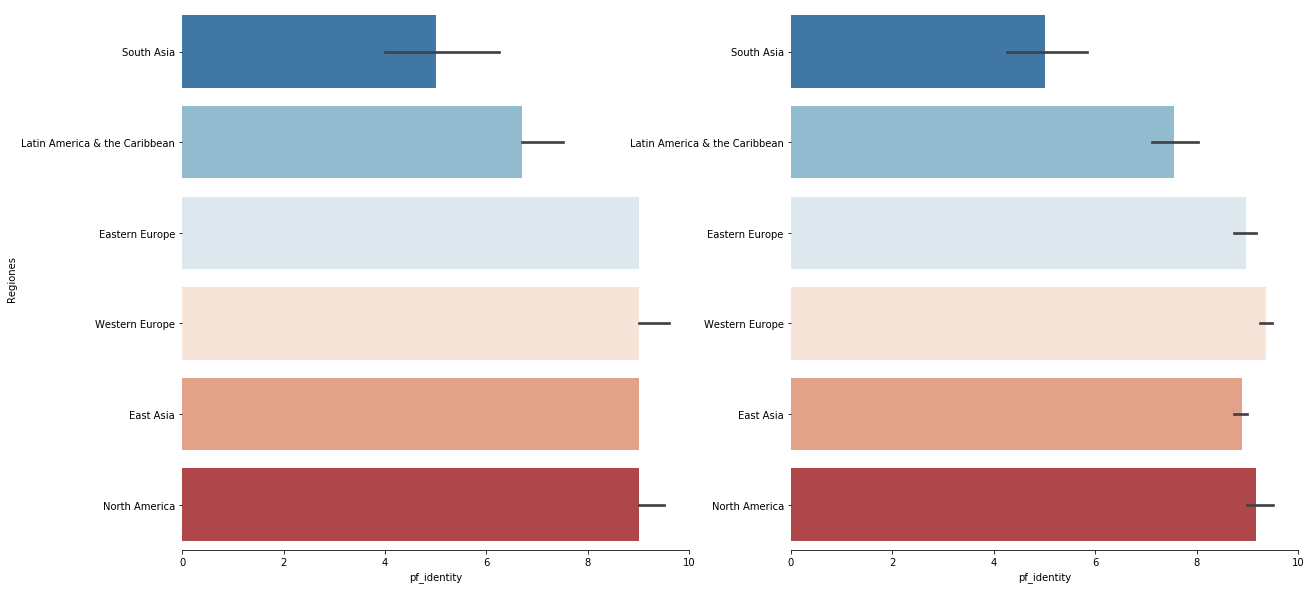

In [13]:
select = dataset[(dataset.region=='Latin America & the Caribbean')|
                 (dataset.region=='North America')|
                 (dataset.region=='Western Europe')|
                 (dataset.region=='Eastern Europe')|
                (dataset.region=='South Asia')|
                (dataset.region=='East Asia')].dropna().sort_values(by=["pf_identity"])

plt.figure (figsize=(20,10))

plt.subplot(121)


sns.barplot(x='pf_identity', y='region', data=select, estimator=np.median, palette="RdBu_r")
plt.ylabel('Regiones')
plt.xlabel('pf_identity')
plt.xlim(0,10)
sns.despine(left=True)

plt.subplot(122)

sns.barplot(x='pf_identity', y='region', data=select, estimator=np.mean, palette="RdBu_r")
plt.ylabel(None)
plt.xlabel('pf_identity')
plt.xlim(0,10)
sns.despine(left=True)


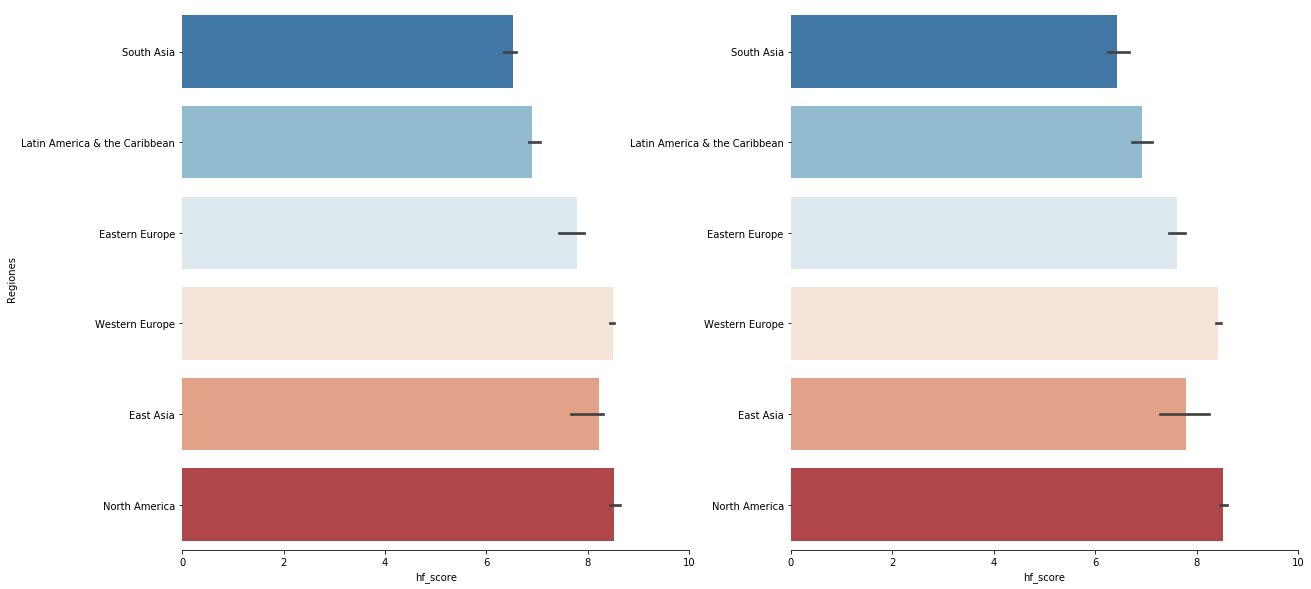

In [14]:
plt.figure (figsize=(20,10))

plt.subplot(121)


sns.barplot(x='hf_score', y='region', data=select, estimator=np.median, palette="RdBu_r")
plt.ylabel('Regiones')
plt.xlabel('hf_score')
plt.xlim(0,10)
sns.despine(left=True)

plt.subplot(122)

sns.barplot(x='hf_score', y='region', data=select, estimator=np.mean, palette="RdBu_r")
plt.ylabel(None)
plt.xlabel('hf_score')
plt.xlim(0,10)
sns.despine(left=True)


En este caso para las regiones la mediana resulta mucho más robusta que la media dado que existe menor variabilidad como se observa en el tamaño de las barras de error de cada uno de los gráficos

#### 3. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.

In [15]:
select_region = dataset[dataset['region']=='Latin America & the Caribbean'][['region','pf_identity','hf_score']].dropna()
group_a = select_region.groupby(['region'],as_index=False).agg({'pf_identity':['mean','median','std'],
                                                                'hf_score':['mean','median','std']}).reset_index()

dataset['world']='Mundo'

world = dataset.dropna().groupby(['world'],as_index=False).agg({'pf_identity':['mean','median','std'],
                                                                'hf_score':['mean','median','std']}).rename(columns={'world':'region'}).reset_index()
df = pd.concat([group_a, world], axis=0)

In [16]:
df.head()

index                         region pf_identity                   hf_score  \
                                              mean median       std      mean   
0     0  Latin America & the Caribbean    8.582171   10.0  1.875832  7.036977   
0     0                          Mundo    7.718831    9.0  2.252780  7.298312   

                    
  median       std  
0   7.02  0.634897  
0   7.30  0.985700

##### Respuesta: 

* En el caso de hf_score tanto la media como la mediana no difieren en mayor cuantia tanto en Latinoamérica como en el mundo.

* En el caso de pf_identity la mediana y la media difieren una de la otra por lo que en el caso de analizar por regiones es conveniente utilizar la mediana como medida de posición ya que la media puede estar alterada por valores extremos.

* Para mayor generalidad y unicidad de criterios en el análisis utilizaremos las mediana como medida de posición
    

 #### 4. ¿Tiene sentido calcular la moda?

Al ser una variables continua no tiene sentido buscar cual es la moda (el valor de mayor ocurrencia). La moda solamente 
tiene sentido en variables discretas o categóricas

####  5. ¿Cómo pueden sanearse los valores faltantes?

En el caso de analizar país si faltan datos en un año se puede imputar el dato del año anterior o promedio del año anterior y posterior al año en que nos falta el dato. Otra forma es que si los datos faltantes se encuentran al comienzo del período se les impute a dichos años el primer dato de la serie.
Es conveniente en nuestro caso conocer no solo la cantidad de casos faltantes por país en nuestro dataset sino además la proporción de estos datos faltantes en el canjunto de datos. En nuestro caso haremos primero un análisis de la cantidad de datos faltantes en todo el set de datos para las variables y luego veremos la cantidad y porcentaje de datos faltantes para cada país. Esto nos permitirá adoptar luego un criterio de exclusión de los países.

**MUNDO**

In [177]:
(dataset[['pf_identity','hf_score','ef_score','pf_score']].isna().sum())

pf_identity    80
hf_score       80
ef_score       80
pf_score       80
dtype: int64

In [178]:
dataset[['pf_identity','hf_score','ef_score','pf_score']].isna().sum()/ len(dataset)*100

pf_identity    4.938272
hf_score       4.938272
ef_score       4.938272
pf_score       4.938272
dtype: float64

In [179]:
missing_world = dataset[['pf_identity','hf_score','ef_score','pf_score']].isna().groupby(dataset['countries']).sum().astype(int)

In [180]:
missing_world[(missing_world.pf_identity>0)|
              (missing_world.hf_score>0)|
             (missing_world.ef_score>0)|
             (missing_world.pf_score>0)].rename(columns={
    'pf_identity':'pf_identity_NaN',
    'hf_score':'hf_score_NaN',
    'ef_score':'ef_score_NaN',
    'pf_score':'pf_score_NaN'})

,pf_identity_NaN,hf_score_NaN,ef_score_NaN,pf_score_NaN
countries,,,,
Belarus,8,8,8,8
Bhutan,5,5,5,5
Brunei Darussalam,2,2,2,2
Cambodia,2,2,2,2
Cape Verde,2,2,2,2
Eswatini,2,2,2,2
"Gambia, The",2,2,2,2
Guinea,5,5,5,5
Iraq,8,8,8,8


In [181]:
count_years = len(dataset.year.unique())
missing_world_pc = missing_world/count_years*100

missing_world_pc = missing_world_pc[(missing_world_pc.pf_identity>0)|
              (missing_world_pc.hf_score>0)|
              (missing_world_pc.ef_score>0)|
             (missing_world_pc.pf_score>0)]

In [182]:
missing_world_pc

,pf_identity,hf_score,ef_score,pf_score
countries,,,,
Belarus,80.0,80.0,80.0,80.0
Bhutan,50.0,50.0,50.0,50.0
Brunei Darussalam,20.0,20.0,20.0,20.0
Cambodia,20.0,20.0,20.0,20.0
Cape Verde,20.0,20.0,20.0,20.0
Eswatini,20.0,20.0,20.0,20.0
"Gambia, The",20.0,20.0,20.0,20.0
Guinea,50.0,50.0,50.0,50.0
Iraq,80.0,80.0,80.0,80.0


**LATINOAMERICA**

In [183]:
latinoamerica = dataset[dataset['region']=='Latin America & the Caribbean'][['countries','year','region',
                                                                             'pf_identity',
                                                                             'hf_score',
                                                                             'ef_score',
                                                                            'pf_score']]



In [184]:
missing_latinoamerica = latinoamerica.isna().groupby(dataset['countries']).sum().astype(int)

In [185]:
missing_latinoamerica = missing_latinoamerica[(missing_latinoamerica.pf_identity>0)|
              (missing_latinoamerica.hf_score>0)|
             (missing_latinoamerica.ef_score>0)|
             (missing_latinoamerica.pf_score>0)]

In [186]:
missing_latinoamerica

,countries,year,region,pf_identity,hf_score,ef_score,pf_score
countries,,,,,,,
Suriname,0,0,0,2,2,2,2


In [187]:
missing_latinoamerica_pc = missing_latinoamerica/count_years*100

In [188]:
missing_latinoamerica_pc

,countries,year,region,pf_identity,hf_score,ef_score,pf_score
countries,,,,,,,
Suriname,0.0,0.0,0.0,20.0,20.0,20.0,20.0


**Eliminaremos de ambos conjuntos aquellos países que tengan más del 40% de las observaciones faltante**

In [189]:
world_countries_miss=missing_world_pc[(missing_world_pc['pf_identity']>40)]['pf_identity'].unique()

In [190]:
latinoamerica_countries_miss=missing_latinoamerica_pc[(missing_latinoamerica_pc['pf_identity']>40)]['pf_identity'].unique()

In [191]:
world = dataset[['year','countries',
                 'region',
                 'pf_identity',
                 'hf_score',
                 'ef_score',
                 'pf_score']][(dataset.isin(world_countries_miss)==False)]

In [192]:
latinoamerica=latinoamerica[(dataset.isin(latinoamerica_countries_miss)==False)]

**Imputar valores perdidos**

Antes de realizar el análisis por país haremos una imputación por promedio para los paises que tienen datos faltantes. Para ello calcularemos el promedio de los indicadores para cada país y luego se lo asignaremos a los valores perdidos 
Imputaremos los valores perdidos que nos quedaron de cada país con su media para todo el periodo

**MUNDO**

In [193]:
mean_country = world.dropna().groupby(['countries'], as_index=False).agg(
    {'pf_identity':'mean','hf_score':'mean','ef_score':'mean','pf_score':'mean'})

mean_country = mean_country.rename(columns={'pf_identity':'pf_identity_miss',
                                            'hf_score':'hf_score_miss',
                                            'ef_score':'ef_score_miss',
                                            'pf_score':'pf_score_miss'})

In [194]:
world_nonull = pd.merge(world,mean_country,how='left',on=['countries'],validate='m:1')
world_nonull['pf_identity'].fillna(world_nonull['pf_identity_miss'],inplace=True)
world_nonull['hf_score'].fillna(world_nonull['hf_score_miss'],inplace=True)
world_nonull['ef_score'].fillna(world_nonull['ef_score_miss'],inplace=True)
world_nonull['pf_score'].fillna(world_nonull['pf_score_miss'],inplace=True)
world_nonull.drop(columns={'pf_identity_miss','hf_score_miss','ef_score_miss','pf_score_miss'},inplace=True)

**LATINOAMERICA**

In [195]:
mean_country = latinoamerica.dropna().groupby(['countries'], as_index=False).agg(
    {'pf_identity':'mean','hf_score':'mean','ef_score':'mean','pf_score':'mean'})

mean_country = mean_country.rename(columns={'pf_identity':'pf_identity_miss',
                                            'hf_score':'hf_score_miss',
                                            'ef_score':'ef_score_miss',
                                            'pf_score':'pf_score_miss'})

In [196]:
latinoamerica_nonull = pd.merge(latinoamerica,mean_country,how='left',on=['countries'],validate='m:1')
latinoamerica_nonull['pf_identity'].fillna(latinoamerica_nonull['pf_identity_miss'],inplace=True)
latinoamerica_nonull['hf_score'].fillna(latinoamerica_nonull['hf_score_miss'],inplace=True)
latinoamerica_nonull['ef_score'].fillna(latinoamerica_nonull['ef_score_miss'],inplace=True)
latinoamerica_nonull['pf_score'].fillna(latinoamerica_nonull['pf_score_miss'],inplace=True)
latinoamerica_nonull.drop(columns={'pf_identity_miss','hf_score_miss','ef_score_miss','pf_score_miss'},inplace=True)

In [197]:
world_nonull.isna().sum()

year           0
countries      0
region         0
pf_identity    0
hf_score       0
ef_score       0
pf_score       0
dtype: int64

In [198]:
latinoamerica_nonull.isna().sum()

countries      0
year           0
region         0
pf_identity    0
hf_score       0
ef_score       0
pf_score       0
dtype: int64

 **6. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? 
    Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?**

Para el estudio de los outliers se sugieren dos métodos: 
* En primer lugar se encuentra el método del rango intercuantilico el cual a partir de calcular la distancia entre el 
    cuantil 25 (Q25) y el 75 (Q75), llamado rango intercuantilico. Luego se consideran outliers aquellos valores que se 
    encuentren fuera del rango [(Q25-IQR);(Q75+IQR)].
* El segundo método comunmente utilizado es el Z-Score. Dicho método consiste en normalizar la variable de la siguiente 
    manera Z=(X-µ)/Õ. Luego se excluyen valores que se encuentren por encima de 3 veces el valor de la normal.

Si el análisis se realiza por región tal como venimos realizando anteriormente es conveniente excluir aquellos países que 
representan un outlier para dicha region. A continuación procederemos a realizar un boxplot por región para las variables 
ht_score y pf_identity. 


**BOXPLOT POR REGION** 

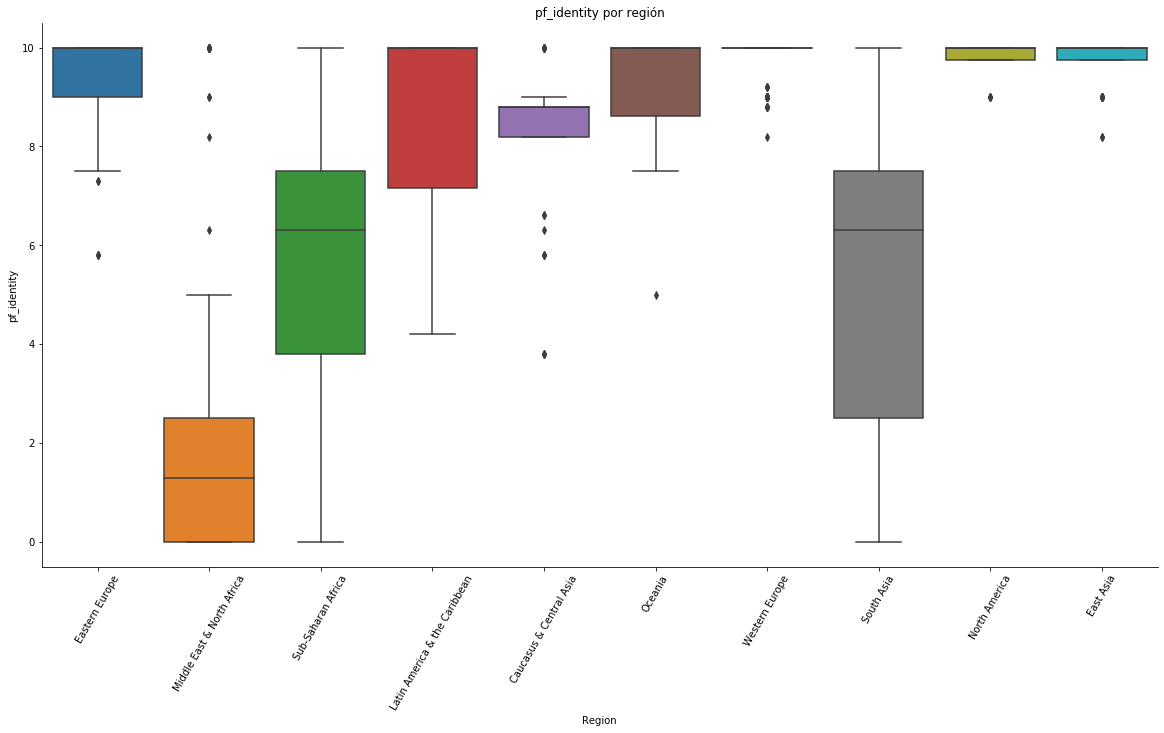

In [199]:
plt.figure (figsize=(20,10))
bp_pf_identity=sns.boxplot(data=world_nonull,
                x='region', y='pf_identity')
plt.title('pf_identity por región')
plt.ylabel('pf_identity')
plt.xlabel('Region')
plt.xticks(rotation=60)
sns.despine()

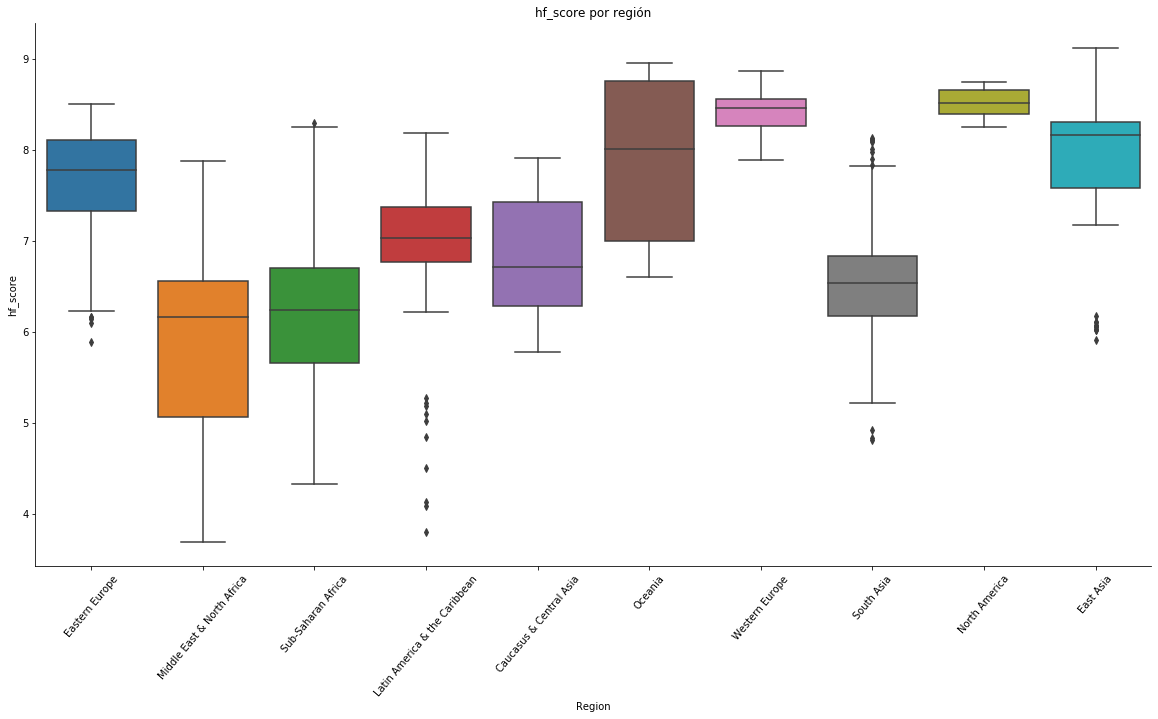

In [200]:
plt.figure (figsize=(20,10))
boxplot=sns.boxplot(data=world_nonull,
                x='region', y='hf_score')
plt.title('hf_score por región')
plt.ylabel('hf_score')
plt.xlabel('Region')
plt.xticks(rotation=50)
sns.despine()

**Utilizando el método Z-Score sacaremos todos los países que tengan outliers**

In [227]:
from scipy import stats
z = stats.zscore(latinoamerica_nonull[['hf_score','pf_identity','ef_score','pf_score']])
Outiliers=latinoamerica_nonull[(np.abs(z) > 2.5).any(axis=1)]['countries'].unique()

In [228]:
latinoamerica_sinOutiliers=latinoamerica_nonull[(latinoamerica_nonull.isin(Outiliers)==False)]

In [233]:
z = stats.zscore(world_nonull[['hf_score','pf_identity','ef_score','pf_score']])
Outiliers=world_nonull[(np.abs(z) > 2.5).any(axis=1)]['countries'].unique()

In [234]:
world_sinOutiliers=world_nonull[(world_nonull.isin(Outiliers)==False)]

In [235]:
world_sinOutiliers.head()

,year,countries,region,pf_identity,hf_score,ef_score,pf_score
0,2017,Albania,Eastern Europe,5.8,7.84,7.67,8.01
1,2017,Algeria,Middle East & North Africa,0.0,4.99,4.77,5.20
2,2017,Angola,Sub-Saharan Africa,5.0,5.40,4.83,5.98
3,2017,Argentina,Latin America & the Caribbean,10.0,6.86,5.67,8.04
4,2017,Armenia,Caucasus & Central Asia,8.2,7.42,7.70,7.15


## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.

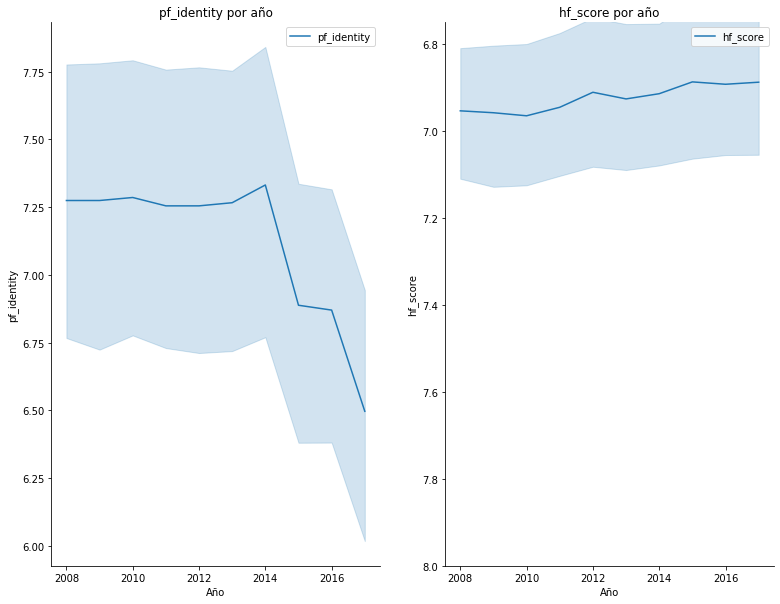

In [236]:
plt.figure (figsize=(20,10))
plt.subplot(131)

lineplot = sns.lineplot(x="year", y="pf_identity",data=world_sinOutiliers, estimator=np.mean,label='pf_identity')
plt.title('pf_identity por año')
plt.ylabel('pf_identity')
plt.xlabel('Año')

plt.subplot(132)

lineplot = sns.lineplot(x="year", y="hf_score",data=world_sinOutiliers, estimator=np.mean,
        label='hf_score')
plt.title('hf_score por año')
plt.ylabel('hf_score')
plt.xlabel('Año')
plt.ylim(8,6.75)
sns.despine()

2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?

La mayoría de las regiones vieron reducida el índice pf_identity a partir del año 2014. En particular Latinoamérica
el índice paso de un promedio de 9 entre 2008-2014 a un promedio de 7.7 a partir del año 2015.

Text(0.5, 0, 'Año')

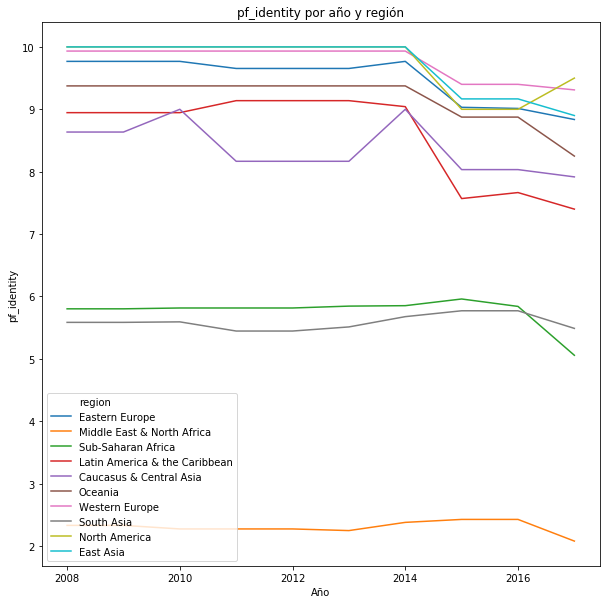

In [237]:
plt.figure (figsize=(10,10))
lineplot = sns.lineplot(x="year", y="pf_identity",data=world_sinOutiliers, estimator=np.mean,
                        hue='region',ci=None,err_style=None)
plt.title('pf_identity por año y región')
plt.ylabel('pf_identity')
plt.xlabel('Año')

Text(0.5, 6.799999999999965, 'Año')

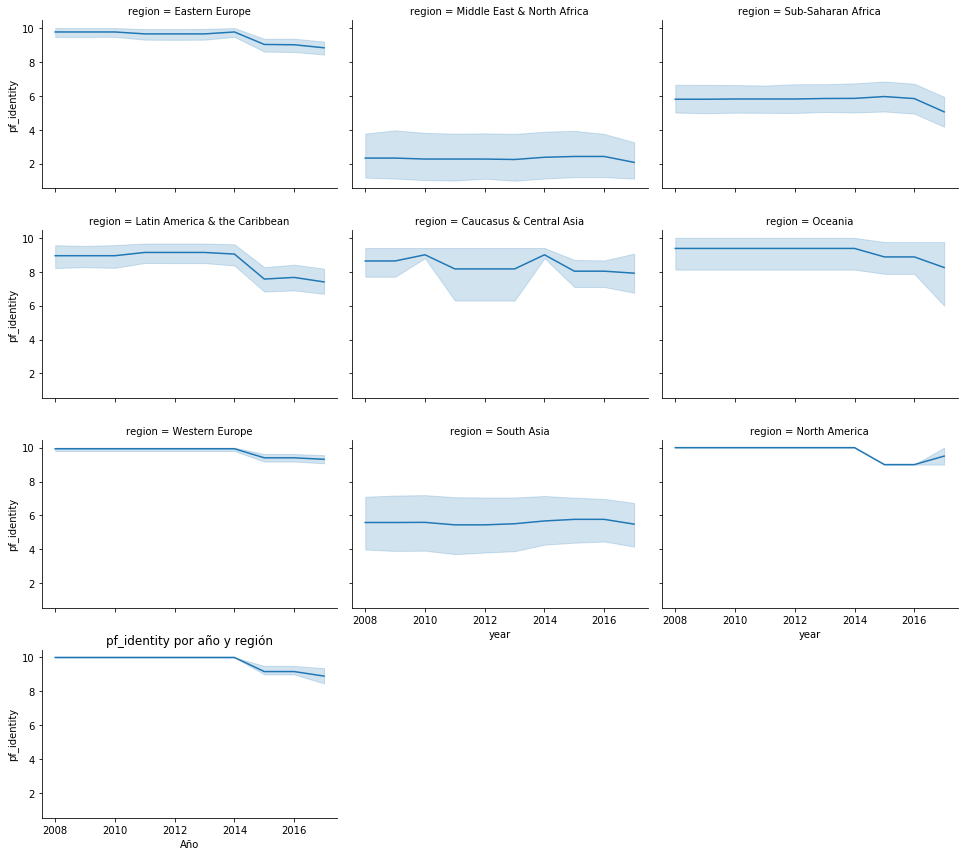

In [238]:
regplot = sns.relplot(x="year", y="pf_identity",data=world_sinOutiliers, estimator=np.mean,
                        col='region',kind="line", col_wrap=3,height=3, aspect=1.5)
plt.title('pf_identity por año y región')
plt.ylabel('pf_identity')
plt.xlabel('Año')

Text(0.5, 0, 'Año')

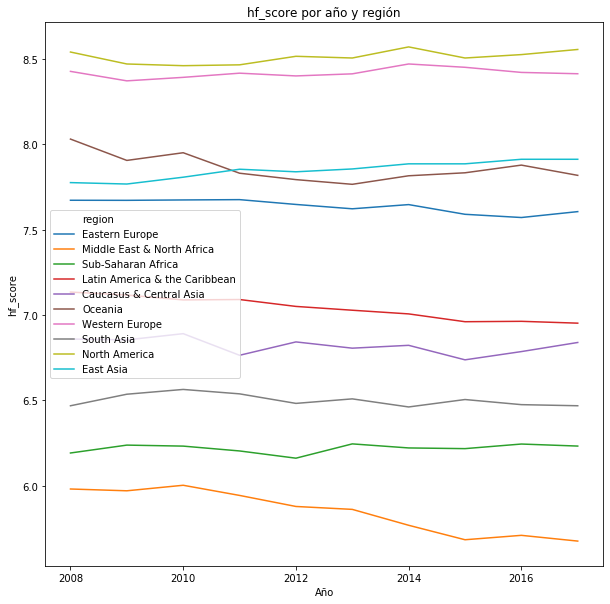

In [239]:
plt.figure (figsize=(10,10))
lineplot = sns.lineplot(x="year", y="hf_score",data=world_sinOutiliers, estimator=np.mean,
                        hue='region',ci=None,err_style=None)
plt.title('hf_score por año y región')
plt.ylabel('hf_score')
plt.xlabel('Año')

Text(0.5, 6.799999999999965, 'Año')

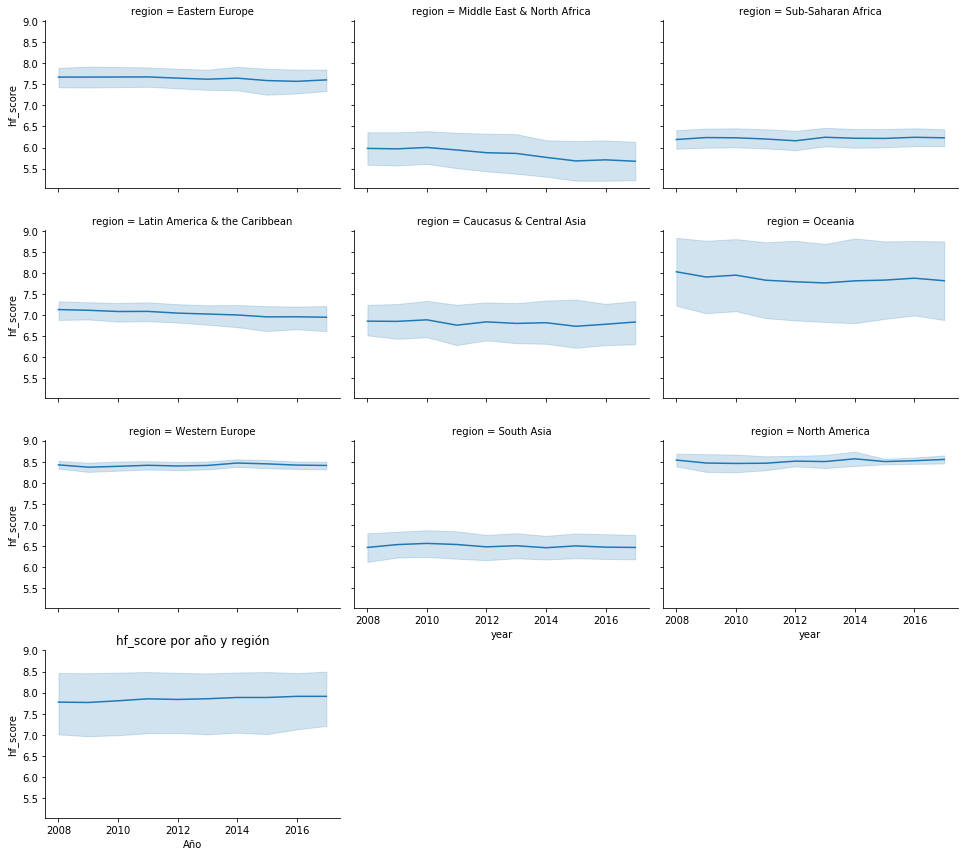

In [240]:
regplot = sns.relplot(x="year", y="hf_score",data=world_sinOutiliers, estimator=np.mean,
                        col='region',kind="line", col_wrap=3,height=3, aspect=1.5)
plt.title('hf_score por año y región')
plt.ylabel('hf_score')
plt.xlabel('Año')

**3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?**

Los países que alteraron relevantes para la tendencia son aquellos que vieron reducida su pf_identity a partir del año 2014 
son los países relevantes en la tendencia y que hicieron que el promedio de la región se hubiese visto alterado en forma
negativa a partir del año 2014. Una forma de seleccionar estos países sería comparar los valores de pf_identitiy para los años 2015-2016 con respecto a los valores observados para el año 2014

Text(0.5, 6.800000000000612, 'Año')

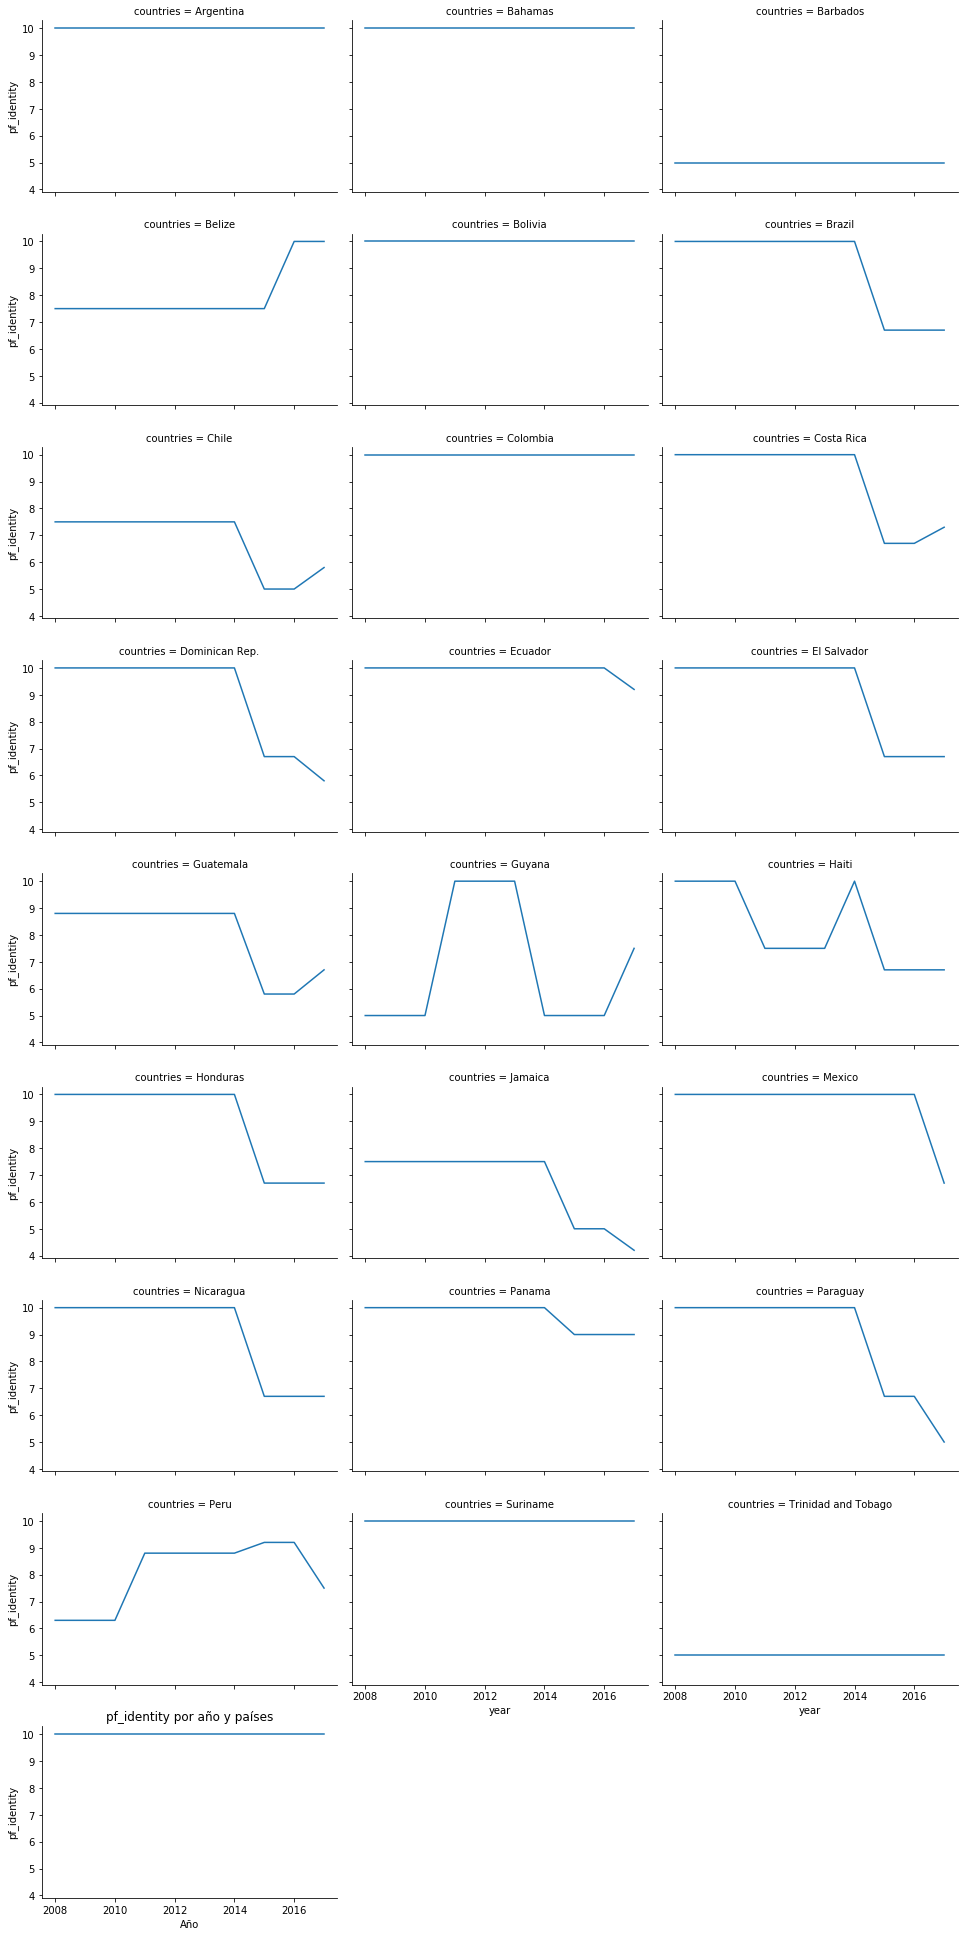

In [243]:
regplot = sns.relplot(x="year", y="pf_identity",data=latinoamerica_sinOutiliers, estimator=np.mean,
                        col='countries',kind="line", col_wrap=3,height=3, aspect=1.5)
plt.title('pf_identity por año y países')
plt.ylabel('pf_identity')
plt.xlabel('Año')

## 3. Distribuciones
 1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?**


Text(0.5, 1.0, 'Distribución de pf_identity para Latinoamerica y Global')

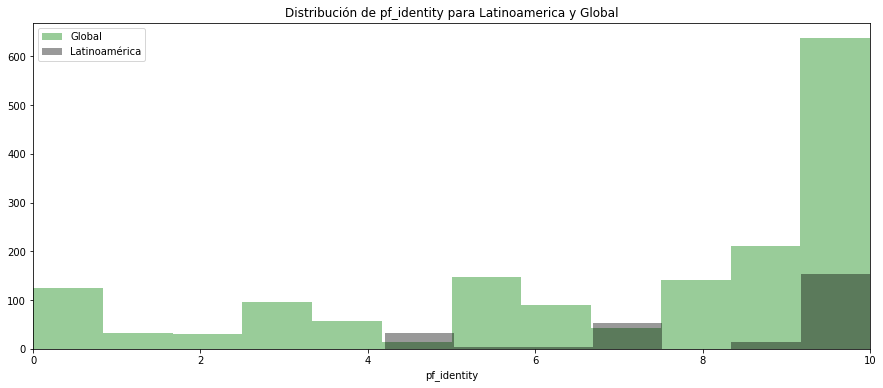

In [255]:
plt.figure (figsize=(15,6))
world=sns.distplot(world_sinOutiliers.pf_identity, 
                   color='green', 
                   label='Global', 
                   kde=False, 
                   hist=True)
latinoamerica=sns.distplot(latinoamerica_sinOutiliers.pf_identity, 
                           color='black', 
                           label='Latinoamérica', 
                           kde=False, 
                           hist=True)

plt.xlabel('pf_identity')
#plt.ylim(0,0.5)
plt.xlim(0,10)
plt.legend()
plt.title('Distribución de pf_identity para Latinoamerica y Global')

Text(0.5, 1.0, 'Distribución de  hf_score para Latinoamerica y Global')

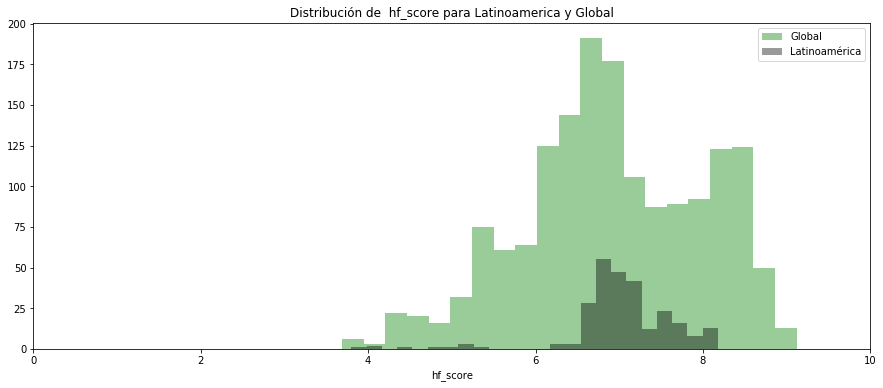

In [257]:
plt.figure (figsize=(15,6))
world=sns.distplot(world_sinOutiliers.
                   hf_score, color='green', 
                   label='Global', 
                   kde=False, 
                   hist=True)
latinoamerica=sns.distplot(latinoamerica_sinOutiliers. hf_score, 
                           color='black', 
                           label='Latinoamérica', 
                           kde=False, 
                           hist=True)
plt.xlabel('hf_score')
plt.xlim(0,10)
plt.legend()
plt.title('Distribución de  hf_score para Latinoamerica y Global')

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

- 'pf_score': Personal Freedom (score).
- 'ef_score': Economic Freedom (score).
- 'hf_score', # Human Freedom (score)
    
Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?

Existe una relación positiva entre pf_score y ef_score. Al mismo tiempo en el caso de la variable pf_identity no resulta adecuado
el gráfico debido a que el mismo posee una gran concentración entre 9-10 por lo que es muy díficil describir una relación de esta variable con las demás variables (pf_score y ef_score).

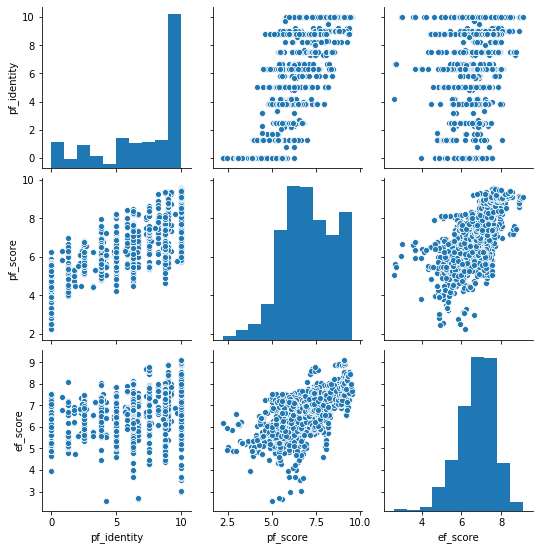

In [260]:
g = sns.pairplot(world_sinOutiliers[['pf_identity','pf_score','ef_score']])

2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.

En el caso de pf_identity y ef_score la relación es levemente positiva aunque la misma presenta heterocedasticidad por lo que 
el efecto no es el mismo en toda la línea de regresión. En el caso de pf_identity y pf_score la relación es positiva y la pendiente es mayor que en el caso de la regresión pf_identity-ef_score.

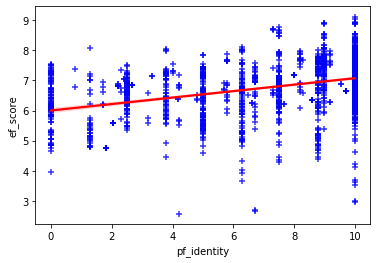

In [271]:
ax = sns.regplot(x="pf_identity", y="ef_score", 
                 marker="+",
                 ci=95,
                 data=world_sinOutiliers,
                 scatter_kws = {'color': 'blue'}, 
                 line_kws = {'color': 'red'})

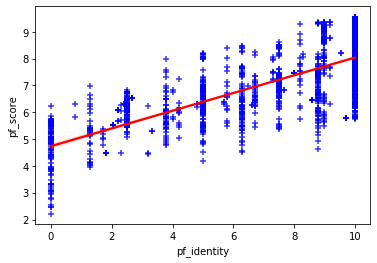

In [272]:
ax = sns.regplot(x="pf_identity", y="pf_score", 
                 marker="+",
                 ci=95,
                 data=world_sinOutiliers,
                 scatter_kws = {'color': 'blue'}, 
                 line_kws = {'color': 'red'})

3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.

Seguiremos los criterios que adopte pd_cut ya que el mismo está hecho para que sea óptima la distribución de valores.

In [280]:
world_sinOutiliers['ef_score_segment']=pd.cut(world_sinOutiliers.ef_score,3, 
                                                  labels=["Low","Medium","High"])

In [281]:
world_sinOutiliers['pf_score_segment']=pd.cut(world_sinOutiliers.hf_score,3, 
                                                  labels=["Low","Medium","High"])

In [282]:
world_sinOutiliers['pf_identity_segment']=pd.cut(world_sinOutiliers.pf_identity,3, 
                                                  labels=["Low","Medium","High"])

4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.


Text(0.5, 1, 'pf_score_segment vs pf_identity_segment')

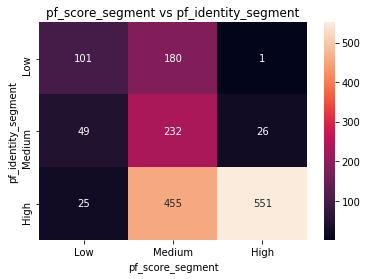

In [290]:
crosstab = pd.crosstab(world_sinOutiliers.pf_identity_segment, world_sinOutiliers.pf_score_segment)
sns.heatmap(crosstab, annot=True, fmt='g')
plt.ylabel('pf_identity_segment')
plt.xlabel('pf_score_segment')
plt.title('pf_score_segment vs pf_identity_segment')

Text(0.5, 1, 'ef_score_segment vs pf_identity_segment')

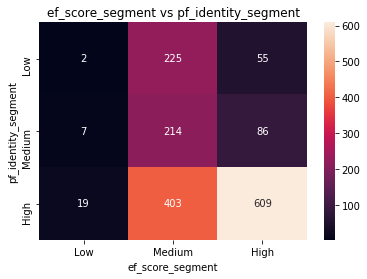

In [291]:
crosstab = pd.crosstab(world_sinOutiliers.pf_identity_segment, world_sinOutiliers.ef_score_segment)
sns.heatmap(crosstab, annot=True, fmt='g')
plt.ylabel('pf_identity_segment')
plt.xlabel('ef_score_segment')
plt.title('ef_score_segment vs pf_identity_segment')

Text(0.5, 1, 'ef_score_segment vs pf_identity_segment')

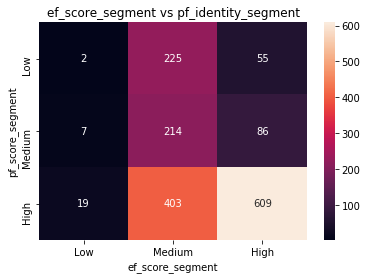

In [292]:
crosstab = pd.crosstab(world_sinOutiliers.pf_identity_segment, world_sinOutiliers.ef_score_segment)
sns.heatmap(crosstab, annot=True, fmt='g')
plt.ylabel('pf_score_segment')
plt.xlabel('ef_score_segment')
plt.title('ef_score_segment vs pf_identity_segment')

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

In [294]:
df = world_sinOutiliers[["pf_identity","pf_score","ef_score","hf_score"]]

In [301]:
ktest_list=[]
p_val_list=[]
mean_list=[]
std_list=[]
conclusion=[]
columns=df.columns
alpha=0.05
d= {}
for i in range(0,len(df.columns)):
    ktest, pval =stats.kstest(df[df.columns[i]], 'norm',args=(df[df.columns[i]].mean(),
                                                            df[df.columns[i]].std()))
    p_val_list.append(pval)
    ktest_list.append(ktest)
    if p_val_list[i]<=alpha:
        conclusion.append('Rechazo H0 - La variable no se distribuye normal')
    else:
        conclusion.append('No rechazo H0 - La variable se distribuye normal')
    mean_list.append(df[df.columns[i]].mean())
    std_list.append(df[df.columns[i]].std())

d = {'Name':columns,
     'Media':mean_list,
     'Std':std_list,
     'P Value':p_val_list,
     'K Test':ktest_list,
     'Conclusion - Test Normalidad':conclusion}
Kolgomorov_Smirnov_Test=pd.DataFrame(d)

In [302]:
Kolgomorov_Smirnov_Test

,Name,Media,Std,P Value,K Test,Conclusion - Test Normalidad
0,pf_identity,7.120000,3.286177,1.517870e-65,0.213924,Rechazo H0 - La variable no se distribuye normal
1,pf_score,7.085110,1.433116,1.865363e-06,0.065335,Rechazo H0 - La variable no se distribuye normal
2,ef_score,6.763353,0.912024,6.367994e-04,0.049739,Rechazo H0 - La variable no se distribuye normal
3,hf_score,6.924272,1.081215,1.484398e-05,0.060254,Rechazo H0 - La variable no se distribuye normal


## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no.

Utilizaremos los diversos coeficientes (pearson, spearman, tau) para calcular las relaciones entre las diferentes variables

**SPEARMAN**

In [308]:
corr_list=[]
p_val_list=[]
correlacion_val = []

for i in range(0,len(df.columns)):
    for j in range(0,len(df.columns)):
        corr, pval =stats.spearmanr(df[df.columns[i]],df[df.columns[j]])
        p_val_list.append(pval)
        corr_list.append(corr)
        correlacion_val.append(df.columns[i]+ '-' +df.columns[j])
    

In [310]:
d = {'Name':correlacion_val,
     'P-Value':p_val_list,
     'Spearman':corr_list}
Spearman=pd.DataFrame(d)
Spearman[Spearman['P-Value']!=0]

,Name,P-Value,Spearman
1,pf_identity-pf_score,2.143921e-288,0.746353
2,pf_identity-ef_score,1.317572e-69,0.418235
3,pf_identity-hf_score,4.187041e-208,0.665878
4,pf_score-pf_identity,2.143921e-288,0.746353
6,pf_score-ef_score,6.063851e-252,0.713194
8,ef_score-pf_identity,1.317572e-69,0.418235
9,ef_score-pf_score,6.063851e-252,0.713194
12,hf_score-pf_identity,4.187041e-208,0.665878


En todos los casos existe una relacion signitivamente distinta de cer (p-valor menor a 0.01). Ademas las correlaciones son positivas. 


***TAU***

In [311]:
corr_list=[]
p_val_list=[]
correlacion_val = []

for i in range(0,len(df.columns)):
    for j in range(0,len(df.columns)):
        corr, pval =stats.kendalltau(df[df.columns[i]],df[df.columns[j]])
        p_val_list.append(pval)
        corr_list.append(corr)
        correlacion_val.append(df.columns[i]+ '-' +df.columns[j])
    

In [313]:
d = {'Name':correlacion_val,
     'PValue':p_val_list,
     'KendallTau':corr_list}
Pearson=pd.DataFrame(d)
Pearson[Pearson.PValue!=0]

,Name,PValue,KendallTau
1,pf_identity-pf_score,5.348642e-234,0.580477
2,pf_identity-ef_score,4.039908e-63,0.298205
3,pf_identity-hf_score,2.864275e-174,0.500339
4,pf_score-pf_identity,5.348642e-234,0.580477
6,pf_score-ef_score,1.032766e-215,0.521166
8,ef_score-pf_identity,4.039908e-63,0.298205
9,ef_score-pf_score,1.032766e-215,0.521166
12,hf_score-pf_identity,2.864275e-174,0.500339


***PEARSON***

In [316]:
corr_list=[]
p_val_list=[]
correlacion_val = []

for i in range(0,len(df.columns)):
    for j in range(0,len(df.columns)):
        corr, pval =stats.mstats.pearsonr(df[df.columns[i]],df[df.columns[j]])
        p_val_list.append(pval)
        corr_list.append(corr)
        correlacion_val.append(df.columns[i]+ '-' +df.columns[j])
d = {'Name':correlacion_val,
     'PValue':p_val_list,
     'Pearson':corr_list}
Pearson=pd.DataFrame(d)    

In [317]:
Pearson[Pearson.PValue!=0]

,Name,PValue,Pearson
1,pf_identity-pf_score,5.879078387733636e-301,0.756699
2,pf_identity-ef_score,9.737335823667246e-59,0.386111
3,pf_identity-hf_score,9.272531648631431e-207,0.664274
4,pf_score-pf_identity,5.879078387733636e-301,0.756699
6,pf_score-ef_score,8.564846842174615e-225,0.684979
8,ef_score-pf_identity,9.737335823667246e-59,0.386111
9,ef_score-pf_score,8.564846842174615e-225,0.684979
12,hf_score-pf_identity,9.272531648631431e-207,0.664274


En todos los metodos de coeficiente de correlacion utilizados (con mayor o menor robutez) se obtuvo la misma conclusión: las correlaciones son signitivamente distintas de cero y positivas

4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

***TEST F-SCORE***
es comunmente utilizado para dos o más grupos de una misma población. Es una
prueba de diferencias, es decir, al menos uno de los grupos es estadísticamente diferente a los demás por lo que no puede
conocerse que grupo es diferente.

In [351]:
col =["region","pf_identity"]
df = world_sinOutiliers[col]
df.region.unique()

array(['Eastern Europe', 'Middle East & North Africa',
       'Sub-Saharan Africa', 'Latin America & the Caribbean',
       'Caucasus & Central Asia', 'Oceania', 'Western Europe',
       'South Asia', 'North America', 'East Asia'], dtype=object)

In [352]:
F, p = stats.f_oneway(df[df.region=='Eastern Europe'].pf_identity,
                      df[df.region=='Middle East & North Africa'].pf_identity,
                      df[df.region=='Sub-Saharan Africa'].pf_identity,
                      df[df.region=='Latin America & the Caribbean'].pf_identity,
                      df[df.region=='Caucasus & Central Asia'].pf_identity,
                      df[df.region=='Oceania'].pf_identity,
                      df[df.region=='Western Europe'].pf_identity,
                      df[df.region=='South Asia'].pf_identity,
                      df[df.region=='North America'].pf_identity,
                      df[df.region=='East Asia'].pf_identity)

In [353]:
if p<0.05:
    print('Acepto la hipótesis nula')
if p>=0.05:
    print('Rechazo la hipótesis nula')

Acepto la hipótesis nula


In [354]:
col =["region","ef_score"]
df = world_sinOutiliers[col]

In [355]:
F, p = stats.f_oneway(df[df.region=='Eastern Europe'].ef_score,
                      df[df.region=='Middle East & North Africa'].ef_score,
                      df[df.region=='Sub-Saharan Africa'].ef_score,
                      df[df.region=='Latin America & the Caribbean'].ef_score,
                      df[df.region=='Caucasus & Central Asia'].ef_score,
                      df[df.region=='Oceania'].ef_score,
                      df[df.region=='Western Europe'].ef_score,
                      df[df.region=='South Asia'].ef_score,
                      df[df.region=='North America'].ef_score,
                      df[df.region=='East Asia'].ef_score)

In [356]:
if p<0.05:
    print('Acepto la hipótesis nula')
if p>=0.05:
    print('Rechazo la hipótesis nula')

Acepto la hipótesis nula


**Prueba Chi-Cuadrado**
es una prueba no paramétrica que permite establecer la correlación entre dos variables categóricas dispuestas
en una tabla de contingencia. En este caso la hipótesis nula es la independencia de las variables. En el caso que se presenta a continuación
las variables resultan independientes



In [357]:
col =["region","pf_score_segment"]
df = world_sinOutiliers[col]
df = pd.crosstab(index=df.region, columns=df.pf_score_segment)

In [358]:
print(df)

pf_score_segment               Low  Medium  High
region                                          
Caucasus & Central Asia          0      40    20
East Asia                        0      12    48
Eastern Europe                   0      52   168
Latin America & the Caribbean   10     178    72
Middle East & North Africa      76     104    10
North America                    0       0    20
Oceania                          0      19    21
South Asia                      12     146    12
Sub-Saharan Africa              77     316    27
Western Europe                   0       0   180


In [359]:
chi2, pvalor, freedom_degrees, expected_frecuencies = stats.chi2_contingency(df, correction=False)

In [360]:
ci = 0.95
crit_value = stats.chi2.ppf(q = ci, df=freedom_degrees)

if chi2>crit_value:
    print('Acepto la hipótesis nula')
if chi2<=crit_value:
    print('Rechazo la hipótesis nula')

Acepto la hipótesis nula
